## Curvas de resposta do controle do gimbal

In [1]:
from matplotlib import cycler
from numpy import pi
import numpy as np
from numpy import array
from matplotlib import pyplot as plt
import matplotlib as mpl
import mplcursors
%matplotlib widget

#---------------------------Parametros Gerais --------------------------------



seaborn_colors = ['#478ea3', '#EE6666', '#9988DD',
                  '#EECC55', '#88BB44', '#FFBBBB','#B82E2E']


charts_js_colors = ['#3366CC', '#DC3912', '#FF9900', '#109618', '#990099', '#3B3EAC', '#0099C6', '#D47', '#6A0',
                    '#B82E2E', '#316395', '#949', '#2A9', '#AA1', '#63C', '#E67300', '#8B0707', '#329262', '#5574A6', '#651067']

color_list = seaborn_colors

colors = cycler('color', color_list)

mpl.rc('axes',titlesize = 9)
mpl.rc('axes',labelsize = 9)
plt.rc('axes', prop_cycle=colors)
plt.rc('grid', color='#00000020', linestyle='dashed')
plt.rc('xtick', direction='in', color='#222')
plt.rc('ytick', direction='in', color='#222')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=1)

dashdotdot = (0,(1,2,1,2))

# mpl.style.use('seaborn')
# preferencia dos graficos
# plt.rcParams['lines.linewidth'] = 1

# plt.tight_layout()

# função para mapear 0 - 2pi para -pi - pi


def f(x: float):
    if x > pi:
        return x-2*pi
    elif x < -pi:
        return x+2*pi
    else:
        return x


# vetorizar a função para aplicar diretamente no array
ang_adj = np.vectorize(f)


# função para mapear 0 - 2pi para -pi - pi
def r2d(x: float):
    return 180*x/pi


# vetorizar a função para aplicar diretamente no array
degree = np.vectorize(r2d)

# cortar curvas usando valores de tempo


def cut(t, low, up):
    if (t[0] > low or t[-1] < up):
        raise Exception(f"Faixa incorreta [{t[0]},{t[-1]}] [{low},{up}]")
    dt = (t[-1]-t[0])/t.size
    i = int((low-t[0])//dt)
    j = int((up-t[0])//dt)
    return i, j

# encontrar o inicio dos testes (quando a referencia sai de 0)


def find_start(ref: np.ndarray) -> int:
    # algumas vezes o inicio não é zero, vamos forçar ser
    ref -= ref[0]
    # posição do primeiro elemento diferente de zero
    return np.nonzero(ref)[0][0]

# encontrar o ponto de regime permanente, passa a curva e os limites


def find_ss(vet, upper, lower):
    i = vet.size-1
    while vet[i] < upper and vet[i] > lower and i != -1:
        i -= 1
    return i


def MDA(v: np.ndarray, t: np.ndarray) -> float:
    """Media da Derivada Absoluta

    Args:
        v (np.ndarray): curva a medir
        t (np.ndarray): tempo para realizar derivada

    Returns:
        float: MDA os the curve
    """
    return np.mean(np.abs(np.divide(np.diff(v), np.diff(t))))


def MSE(e: np.array):
    """Calcula o Mean Squared Error

    Args:
        e (np.array): array com valores da curva

    Returns:
        number: valor final
    """
    return np.square(e).mean()




### Rapida curva do tracking de cores com mudança na referencia

São feitos 3 plots comparando as referencias aos valores de posição do objeto na tela e da rotação.

O video da resposta esta gravado:

In [2]:
from IPython.display import Video
Video("cores_2.mp4")

[Text(0, 0.5, 'Rotação (rad)')]

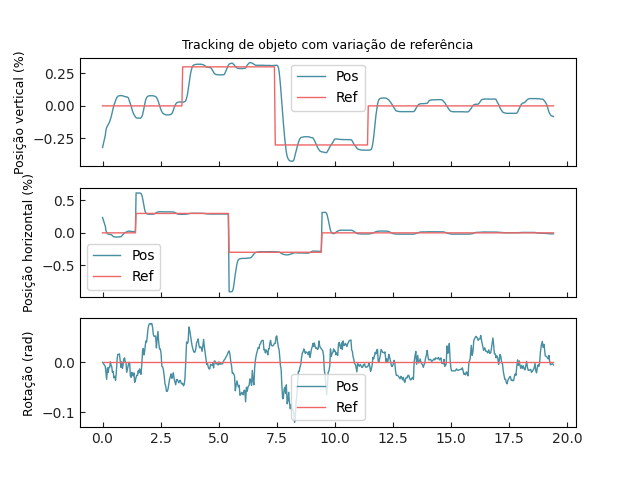

In [3]:
file = 'curva_cores_ref.txt'

[x1, y1, ang1, x2, y2, ang2, t] = np.loadtxt(file, unpack=True)
# y = data[:,1]
t = t - t[0]  # inicia tempo com 0

x1 = x2+x1
y1 = y2+y1

fig,(ax,ay,an) = plt.subplots(3)
mplcursors.cursor(hover=True)
ax.plot(t, y1, t, y2)
ax.set_title('Tracking de objeto com variação de referência')
ax.legend(['Pos','Ref'])
ax.set(ylabel='Posição vertical (%)')
ax.label_outer()
# ay.set_title('Resposta da camera em tracking de objeto')
ay.plot(t,x1,t,x2)
ay.legend(['Pos','Ref'])
ay.label_outer()
ay.set( ylabel='Posição horizontal (%)')

an.plot(t,ang1,t,ang2)
an.legend(['Pos','Ref'])
an.set( ylabel='Rotação (rad)')
# ax.show()


### Curvas sem feedback da camera

É possivel fazer 3 testes com o controle do gimbal sem a camera
1. base parada e mudança de setpoint.
   Dados de 3 eixos, referencia e saida

2. base se movendo(disturbio) e setpoint fixo
3. disturbio + setpoint variavel

## CURVA ZERO

Primeiro mostrar o gimbal parado e como o PI junto com o zona morta e a folga atrapalham

Os testes mostram o erro em regime depois de um disturbio, como e sem o limitação no integrador

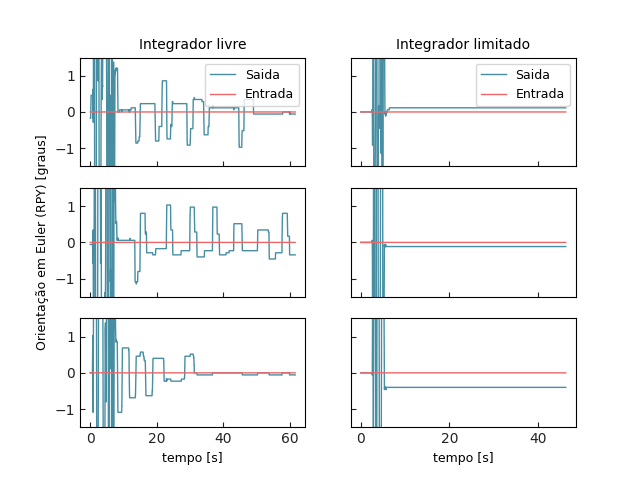

In [4]:
fig,ax = plt.subplot_mosaic([['yi','y'],['pi','p'],['ri','r']])

#como não interessa o disturbio anterior vamos focar na escala do erro em regime permanente
for a in ax:
    ax[a].set_ylim(ymin=-1.5,ymax=1.5)

file = 'curvas_1/parado_integrador_livre.txt'

#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0

# nesse caso a referencia começou diferente de 0, mas para facilitar a visualização vamos trazer tudo para zero
r = r - r2[0]
r2 = r2 - r2[0]
p = p - p2[0]
p2 = p2 - p2[0]
y = y - y2[0]
y2 = y2 - y2[0]

r = ang_adj(r)

ags = [r, p, y, r2, p2, y2]
[r, p, y, r2, p2, y2] = degree(ags)

ax['yi'].set_title('Integrador livre',fontsize='10')
ax['yi'].plot(t, y, t, y2)
ax['yi'].legend(['Saida','Entrada'],fontsize='9')
ax['yi'].label_outer()

# ax['pi'].set(ylabel='Posição Angular [graus]')
ax['pi'].set(ylabel='Orientação em Euler (RPY) [graus]')
ax['pi'].plot(t,p,t,p2)
ax['pi'].label_outer()

ax['ri'].plot(t,r,t,r2)
ax['ri'].set(xlabel='tempo [s]')

#-----------------------------------------------------

file = 'curvas_1/parado_integrador_limitado.txt'


[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0

# nesse caso a referencia começou diferente de 0, mas para facilitar a visualização vamos trazer tudo para zero
r = r - r2[0]
r2 = r2 - r2[0]
p = p - p2[0]
p2 = p2 - p2[0]
y = y - y2[0]
y2 = y2 - y2[0]

r = ang_adj(r)

ags = [r, p, y, r2, p2, y2]
[r, p, y, r2, p2, y2] = degree(ags)

ax['y'].set_title('Integrador limitado',fontsize='10')
ax['y'].plot(t,y,t,y2)
ax['y'].legend(['Saida','Entrada'],fontsize='9')
ax['y'].label_outer()


ax['p'].plot(t,p,t,p2)
ax['p'].label_outer()

ax['r'].plot(t,r,t,r2)
ax['r'].set(xlabel='tempo [s]')
ax['r'].label_outer()



In [5]:
#salvar
fig.set_size_inches(7,5)
# plt.savefig("imagens/integrador_limit.svg")

Agora com integrador limitado

[Text(0, 0.5, 'Pitch [deg]')]

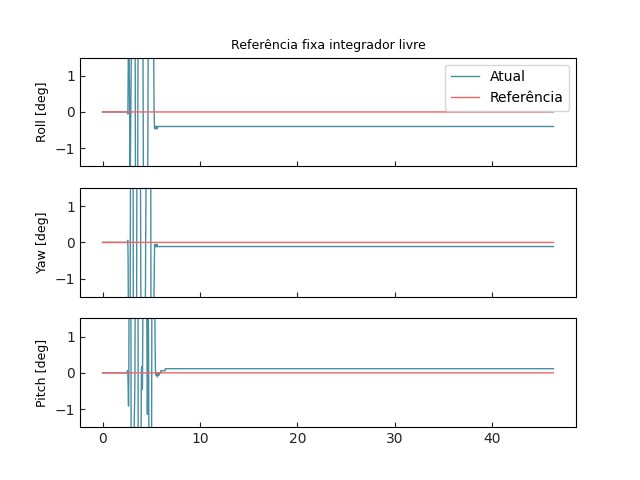

In [6]:
file = 'curvas_1/parado_integrador_limitado.txt'

#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0

# nesse caso a referencia começou diferente de 0, mas para facilitar a visualização vamos trazer tudo para zero
r = r - r2[0]
r2 = r2 - r2[0]
p = p - p2[0]
p2 = p2 - p2[0]
y = y - y2[0]
y2 = y2 - y2[0]

r = ang_adj(r)

ags = [r, p, y, r2, p2, y2]
[r, p, y, r2, p2, y2] = degree(ags)

fig,(ar,ap,ay) = plt.subplots(3)

#como não interessa o disturbio anterior vamos focar na escala do erro em regime permanente
ar.set_ylim(ymin=-1.5,ymax=1.5)
ap.set_ylim(ymin=-1.5,ymax=1.5)
ay.set_ylim(ymin=-1.5,ymax=1.5)

ar.plot(t, r, t, r2)
ar.set_title('Referência fixa integrador livre')
ar.legend(['Atual','Referência'])
ar.set(ylabel='Roll [deg]')
ar.label_outer()
# ay.set_title('Resposta da camera em tracking de objeto')
ap.plot(t,p,t,p2)
# ap.legend(['Pos','Ref'])
ap.set( ylabel='Yaw [deg]')
ap.label_outer()

ay.plot(t,y,t,y2)
# ay.legend(['Pos','Ref'])
ay.set( ylabel='Pitch [deg]')

## Primeira Curva

Mudança na referência da orientação


## Metodo da sensibilidade limite

Tabela de Ziegler e Nichols

|     | Kp     | Ti     | Td       |
|-----|--------|--------|----------|
| PID | 0.6Kcr | 0.5Pcr | 0.125Pcr |

Os teste da sensibilidade limite foram feitos com cada motor, enquanto os outros motores se mantinham parados, ou melhor, inercia constante.

[Text(0.5, 0, 'tempo [s]')]

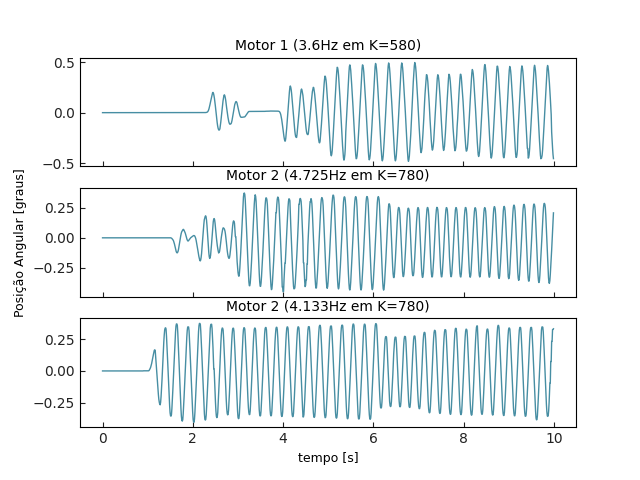

In [7]:


file = 'curvas_1/sensiblimit_1.txt'

#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0
r = ang_adj(r)
r = r - r2[0]
i,j =cut(t,0,10)

fig,ax= plt.subplots(3)
ax[0].plot(t[i:j],r[i:j])
ax[0].set_title("Motor 1 (3.6Hz em K=580)",fontsize="10")
ax[0].label_outer()
#frequencia em KP 580 = 3.6Hz


file = 'curvas_1/sensiblimit_2.txt'

[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0
p = p - p2[0]
# p= degree(p)
i,j =cut(t,0,10)
# fig,ax= plt.subplots()
ax[1].plot(t[i:j],p[i:j])
ax[1].set(ylabel="Posição Angular [graus]")
ax[1].set_title("Motor 2 (4.725Hz em K=780)",fontsize="10")
ax[1].label_outer()

#frequencia em KP 780 = 4.725Hz


file = 'curvas_1/sensiblimit_3.txt'

[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)
t = t - t[0]  # inicia tempo com 0
y = y - y2[0]
# p= degree(p)
i,j =cut(t,0,10)
# fig,ax= plt.subplots()
ax[2].plot(t[i:j],y[i:j])
ax[2].set_title("Motor 2 (4.133Hz em K=780)",fontsize="10")
ax[2].set(xlabel="tempo [s]")

#frequencia em KP 780 = 4.133Hz


In [8]:
np.set_printoptions(suppress=True)

Pcr = array([0.2777,0.2116,0.2419])
Kcr = array([580,780,780])

Kp = 0.6*Kcr
Ti = 0.5*Pcr
Td = 0.125*Pcr

a = [Pcr,Kcr,Kp,Ti,Td]
# print(np.transpose(a))
print(a)

#PD

Kp = 0.8*Kcr
Ti = 0*Pcr
Td = 0.125*Pcr
a = [Pcr,Kcr,Kp,Ti,Td]
# print(np.transpose(a))
print(a)

[array([0.2777, 0.2116, 0.2419]), array([580, 780, 780]), array([348., 468., 468.]), array([0.13885, 0.1058 , 0.12095]), array([0.0347125, 0.02645  , 0.0302375])]
[array([0.2777, 0.2116, 0.2419]), array([580, 780, 780]), array([464., 624., 624.]), array([0., 0., 0.]), array([0.0347125, 0.02645  , 0.0302375])]


Valores encontrados de cada motor foram:

|Motor|Pcr|Kcr|-|Kp|Ti|Td|
|-----|---|---|-|-|-|-|
|1|0.2777|580|-|348|0.1388|0.0347|
|2|0.2116|780|-|468|0.1058|0.0226|
|3|0.2419|780|-|468|0.1209|0.0302|

Sem overshoot

|Motor|Pcr|Kcr|-|Kp|Ti|Td|
|-----|---|---|-|-|-|-|
|1|0.2777|580|-|116|0.1388|0.091641|
|2|0.2116|780|-|156|0.1058|0.069828|
|3|0.2419|780|-|156|0.1209|0.079827|

Comparativo entre a sintonia com ziglier Nichols e um pequeno ajuste, ou a remoção do integrativo

22.411633169655705 17.042091992267522 13.397246540346748
-13.349916626548183 3.686
21.39697046979113 19.764982692697906 14.987034492310167
-4.698253920072751 3.679000000000002


Text(0.5, 0.98, 'Controle da orientação sem visão e sem distúrbio')

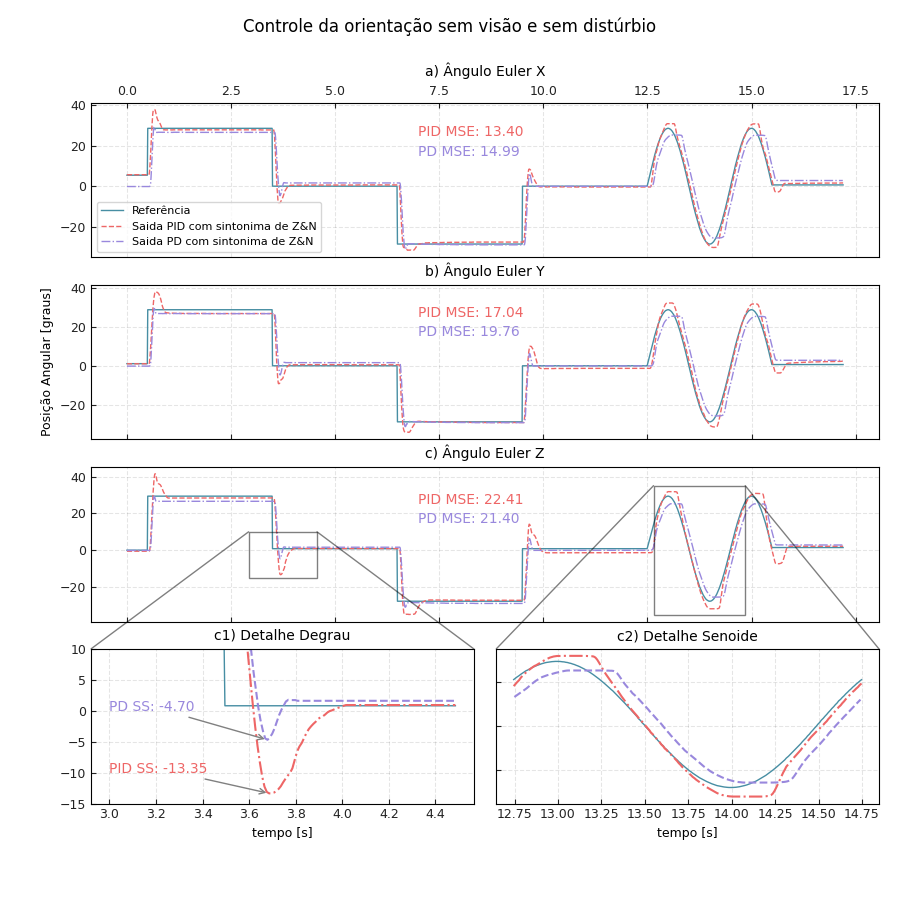

In [9]:
mosaic = [['yaw','yaw'],
['pit','pit'],
['rol','rol'],
['zoom_deg','zoom_sin']]

fig,ax = plt.subplot_mosaic(mosaic)

ax['yaw'].set_title('a) Ângulo Euler X',fontsize="10")
ax['yaw'].tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

ax['pit'].set(ylabel='Posição Angular [graus]')
ax['pit'].set_title('b) Ângulo Euler Y',fontsize="10")
# ax['pit'].label_outer()

ax['rol'].set_title('c) Ângulo Euler Z',fontsize="10")

ax['zoom_deg'].set_title('c1) Detalhe Degrau',fontsize="10")
ax['zoom_deg'].set(xlabel='tempo [s]')
ax['zoom_sin'].set_title('c2) Detalhe Senoide',fontsize="10")
ax['zoom_sin'].set(xlabel='tempo [s]')

for a in ax:
    ax[a].tick_params(direction='in', labelsize='9')
    ax[a].grid(which='major', alpha=0.1)
    ax[a].label_outer()

#------------------------------------------------------------------
file = 'curvas_1/orient_ref_only_Z_N.txt'

#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)

#alguns ponto antes da primeira mudança de ref
start_point = find_start(r2) - 50
t = t - t[start_point]  # inicia tempo com 0
i,j = cut(t,0,17.2)

[r, p, y, r2, p2, y2] = degree([r, p, y, r2, p2, y2])

r_mse = MSE(r-r2)
p_mse = MSE(p-p2)
y_mse = MSE(y-y2)
print(r_mse,p_mse,y_mse)

#plot MSE
ax['yaw'].annotate(text=f'PID MSE: {y_mse:.2f}',
            xy=(7,25),color='#EE6666')
ax['pit'].annotate(text=f'PID MSE: {p_mse:.2f}',
            xy=(7,25),color='#EE6666')
ax['rol'].annotate(text=f'PID MSE: {r_mse:.2f}',
            xy=(7,25),color='#EE6666')

dashdash = (0,(3,3))
densedot = (0,(1,0.5))

ax['yaw'].plot(t[i:j],y2[i:j],'-')
ax['yaw'].plot(t[i:j],y[i:j],'--')

ax['pit'].plot(t[i:j],p2[i:j],'-')
ax['pit'].plot(t[i:j],p[i:j],'--')

ax['rol'].plot(t[i:j],r2[i:j],'-')
ax['rol'].plot(t[i:j],r[i:j],'--')


i,j = cut(t,3,4.5)
ax['zoom_deg'].plot(t[i:j],r2[i:j])
ax['zoom_deg'].plot(t[i:j],r[i:j],'-.', linewidth=1.5)

#------------------------------------------------------------------
#infos
#sobre sinal
iss = np.argmin(r[i:j]) - 0
ss = (r[i:j])[iss]
tss = (t[i:j])[iss]
print(ss, tss)
# tempo de assentamento

#instante de acentamento
its = find_ss(r[i:j],2,-2)
#instante da mudança de referencia
iref = find_start(r2)
#diferença
ts = t[its]-t[iref]


ax['zoom_deg'].annotate(f'PID SS: {ss:.2f}',
            xy=(tss, ss),xycoords='data',
            xytext=(3,-10),textcoords='data', color='#EE6666',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='grey'))

#------------------------------------------------------------------

i,j = cut(t,12.75,14.75)
ax['zoom_sin'].plot(t[i:j],r2[i:j])
ax['zoom_sin'].plot(t[i:j],r[i:j],'-.', linewidth=1.5)


file = 'curvas_1/orient_ref_only_PD.txt'
#roll pitch yaw
[r, p, y, r2, p2, y2, t] = np.loadtxt(file, unpack=True)



#alguns ponto antes da primeira mudança de ref
start_point = find_start(r2) - 50
#define 0 como inicio
t = t - t[start_point]
i,j = cut(t,0,17.2)
[r, p, y, r2, p2, y2] = degree([r, p, y, r2, p2, y2])

r_mse = MSE(r-r2)
p_mse = MSE(p-p2)
y_mse = MSE(y-y2)
print(r_mse,p_mse,y_mse)

#plot MSE
ax['yaw'].annotate(text=f'PD MSE: {y_mse:.2f}',
            xy=(7,15),color='#9988DD')
ax['pit'].annotate(text=f'PD MSE: {p_mse:.2f}',
            xy=(7,15),color='#9988DD')
ax['rol'].annotate(text=f'PD MSE: {r_mse:.2f}',
            xy=(7,15),color='#9988DD')


ax['yaw'].plot(t[i:j],r[i:j],'-.')
ax['pit'].plot(t[i:j],r[i:j],'-.')
ax['rol'].plot(t[i:j],r[i:j],'-.')

i,j = cut(t,3,4.5)
ax['zoom_deg'].plot(t[i:j],r[i:j],'--',linewidth=1.5)

ax['zoom_deg'].set_ylim([-15, 10])
ax['rol'].indicate_inset_zoom(ax['zoom_deg'],edgecolor="black")

#infos------------------------------------------------------
#sobre sinal
iss = np.argmin(r[i:j]) - 0
ss = (r[i:j])[iss]
tss = (t[i:j])[iss]
print(ss, tss)
# tempo de assentamento

#instante de acentamente
its = find_ss(r[i:j],2,-2)
#instante da mudança de referencia
iref = find_start(r2)#r2[i:j].tolist().index(0)
#diferença
ts = t[its]-t[iref]


ax['zoom_deg'].annotate(f'PD SS: {ss:.2f}',
            xy=(tss, ss),xycoords='data',
            xytext=(3,0),textcoords='data', color='#9988DD',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='grey'))

#--------------------------------------------------------                  


i,j = cut(t,12.75,14.75)
ax['zoom_sin'].plot(t[i:j],r[i:j],'--',linewidth=1.5)
ax['rol'].indicate_inset_zoom(ax['zoom_sin'], edgecolor="black")

# ax.plot(t[i:j],r[i:j],'--',linewidth=1.5)



ax['yaw'].legend(['Referência','Saida PID com sintonima de Z&N','Saida PD com sintonima de Z&N'],fontsize=8,loc='lower left')
fig.tight_layout(h_pad=-1.5)
fig.set_size_inches(9,9)
fig.suptitle("Controle da orientação sem visão e sem distúrbio")

# plt.savefig("imagens/orient_sem_disturb_PID.svg",pad_inches=0)

# Sem Visão e com Disturbio

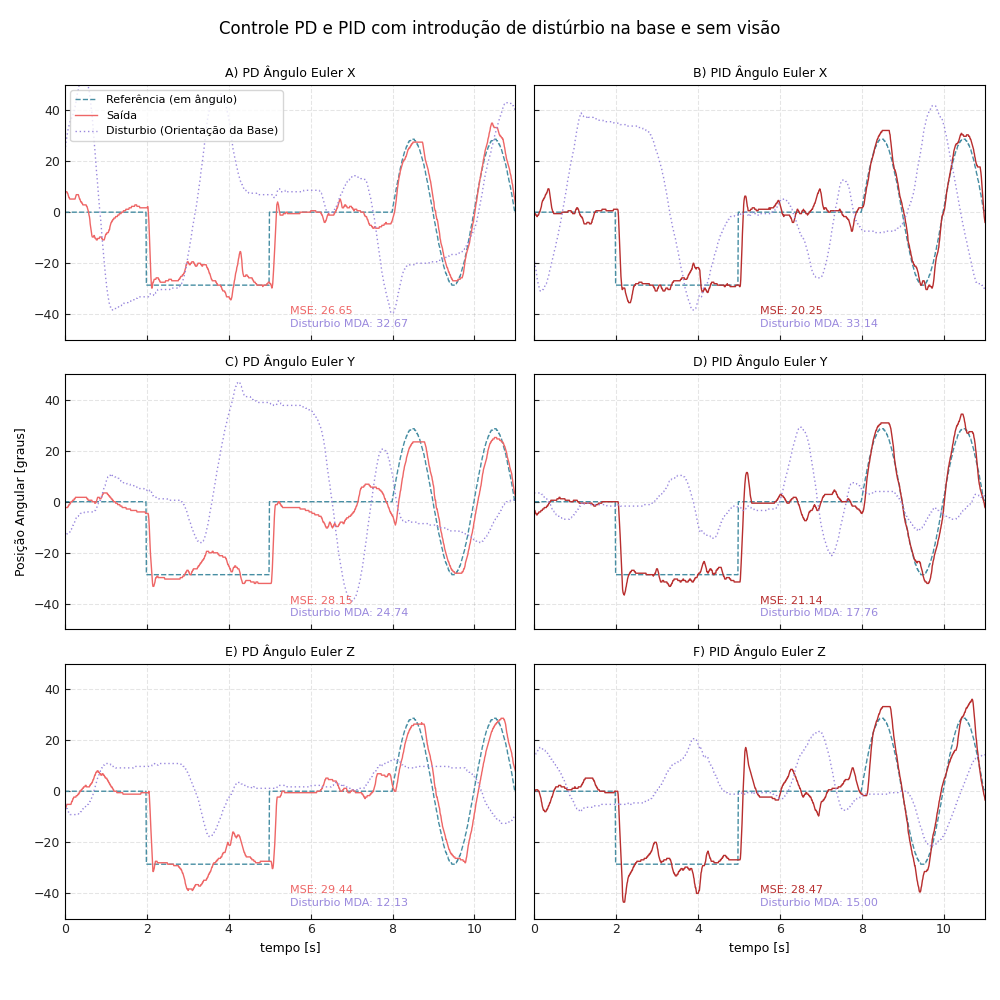

In [10]:
DATA_FILES = {
    'PD': 'curvas_1/orient_ref_disturb_PD.txt',
    'PID': 'curvas_1/orient_ref_disturb_PID.txt',
}

CTRL_NAMES = ['PD', 'PID']
CURVE_NAMES = ['ref', 'out', 'disturb']
ANGLE_NAMES = ['y', 'p', 'r']

start_time =  9

data = {}
t = dict()
for ctrl in CTRL_NAMES:
    df = np.genfromtxt(DATA_FILES[ctrl],
                       delimiter=' ', names=True, dtype=float)

    #traz o inicio do tempo para zero
    t[ctrl] = df['time'] - df['time'][0] - start_time
    # load and rename curves
    data[ctrl] = {}
    for c in CURVE_NAMES:
        data[ctrl][c] = df[[('y_' + c), ('p_' + c), ('r_' + c)]]
        data[ctrl][c].dtype.names = 'y', 'p', 'r'


# -----------------------------METRICS AND ADJUSTMENTS--------------------------------

# devido a um erro na aquisição de dados os valores estão invertidos, é preciso corrigir
# data['PD']['out']['p'] *= -1
# data['PID']['out']['p'] *= -1

# # Valores do disturbio também parecem estar invertidos
# for ctrl in CTRL_NAMES:
#     for ang in ANGLE_NAMES:
#         data[ctrl]['disturb'][ang] *= -1


mse = {}
mda = {}
# soma o erro na referencia para obter a saida
for ctrl in CTRL_NAMES:
    mse[ctrl] = {}
    mda[ctrl] = {}
    for ang in ANGLE_NAMES:
        # Calcula o MSE do erro antes
        mda[ctrl][ang] = MDA(degree(data[ctrl]['disturb'][ang]), t[ctrl])
        mse[ctrl][ang] = MSE(
            degree(data[ctrl]['ref'][ang] - data[ctrl]['out'][ang]))
        # tranforma erro em saida
        # data[ctrl]['out'][ang] = data[ctrl]['ref'][ang] - \
        #     data[ctrl]['out'][ang]

# --------------------------- SUBPLOT CONFIGURATION ------------------------
mosaic = [['y_PD','y_PID'],
          ['p_PD','p_PID'],
          ['r_PD','r_PID']]

gs_kw = dict(height_ratios=[1, 1, 1])

fig = plt.figure()
ax = fig.subplot_mosaic(mosaic, gridspec_kw=gs_kw)

base_ylim = [-50, 50]
base_xlim = [9- start_time, 20- start_time]

ax_config = {
    'PD': {
        'y': {'title': 'A) PD Ângulo Euler X'},
        'p': {'title': 'C) PD Ângulo Euler Y',
              'ylabel': 'Posição Angular [graus]', },
        'r': {'title': 'E) PD Ângulo Euler Z',
              'xlabel': 'tempo [s]', }
    },
    'PID': {
        'y': {'title': 'B) PID Ângulo Euler X'},
        'p': {'title': 'D) PID Ângulo Euler Y',
              'ylabel': 'Posição Angular [graus]', },
        'r': {'title': 'F) PID Ângulo Euler Z',
              'xlabel': 'tempo [s]', }
    },
}


curve_config = {
    'PD': {
        'ref': {'linestyle': '--', 'color': color_list[0]},
        'out': {'linestyle': '-', 'color': color_list[1]},
        'disturb': {'linestyle': dashdotdot, 'color': color_list[2]},
    },
    'PID': {
        'ref': {'linestyle': '--', 'color': color_list[0]},
        'out': {'linestyle': '-', 'color': color_list[6]},
        'disturb': {'linestyle': dashdotdot, 'color': color_list[2]},
    }
}


# ---------------------------PLOT------------------------
for ctrl in CTRL_NAMES:
    for ang in ANGLE_NAMES:
        ax_name = ang + '_' + ctrl
        ax[ax_name].set(xlim = base_xlim, ylim=base_ylim, **ax_config[ctrl][ang])
        ax[ax_name].tick_params(direction='in', labelsize='9')
        ax[ax_name].label_outer()
        ax[ax_name].grid(which='major', alpha=0.1)
        for curve in CURVE_NAMES:
            ax[ax_name].plot(
                t[ctrl],
                degree(data[ctrl][curve][ang]),
                **curve_config[ctrl][curve])


# -----------------------------ANOTATIONS--------------------------------
mse_config = {
    'PD': {'xy': (5.5, -40)},
    'PID': {'xy': (5.5, -40)}
}
mda_config = {
    'PD': {'xy': (5.5, -45)},
    'PID': {'xy': (5.5, -45)}
}

for ang in ['y', 'p', 'r']:
    for ctrl in ['PD', 'PID']:
        ax_name = ang + '_' + ctrl
        ax[ax_name].annotate(text=f'MSE: {mse[ctrl][ang]:.2f}',
                             color=curve_config[ctrl]['out']['color'],
                             fontsize=8,
                             **mse_config[ctrl])

        ax[ax_name].annotate(text=f'Disturbio MDA: {mda[ctrl][ang]:.2f}',
                             color=curve_config[ctrl]['disturb']['color'],
                             fontsize=8,
                             **mda_config[ctrl])

# ---------------------------------------------------------------------

ax['y_PD'].legend(['Referência (em ângulo)',
                   'Saída', 'Disturbio (Orientação da Base)'], fontsize=8, loc='upper left')

d=0.015
# kwargs = dict(transform=ax['y_PD'].transAxes, color='#0004', linestyle='-.', linewidth=4, clip_on=False)
# ax['y_PD'].plot((0.5, 0.5), (0, 1), **kwargs)
# ax['yaw2'].legend(['Referência de Posição (em ângulo)',
#                   'Saída', 'Disturbio (Orientação da Base)'], fontsize=8)

fig.set_size_inches(10, 10)
# fig.subplots_adjust(wspace=0)
# plt.subplot_tool()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(
    "Controle PD e PID com introdução de distúrbio na base e sem visão")


plt.savefig("imagens/orient_PD_PID.svg",pad_inches=0)

# Visão sem Disturbio

Diferença entre instantes das duas amostragens:  2
0.03700000000003456


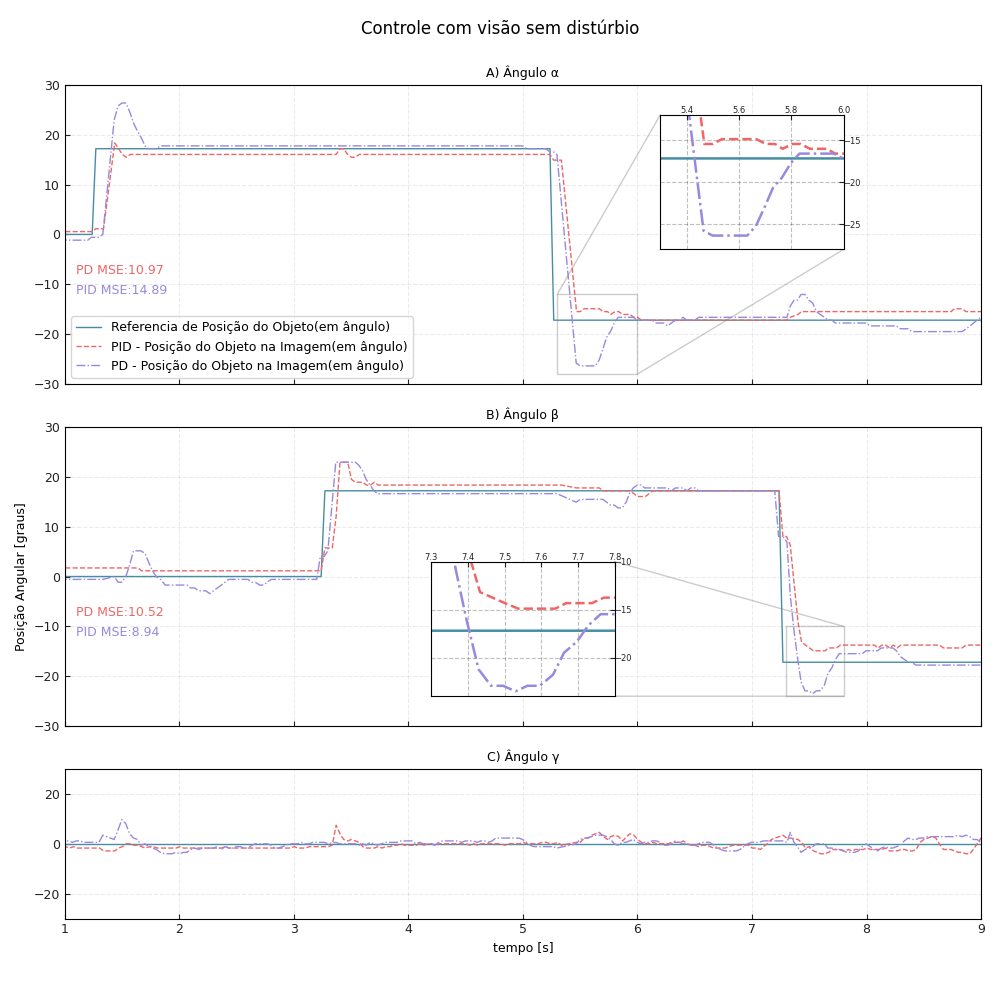

In [11]:
df = np.genfromtxt('curvas_1/visao_semdisturb_PD.txt',
                   delimiter=' ', names=True, dtype=float)
time = {}

start_time = 0
time['ref'] = df['time']
# inicioa com tempo em 0
time['ref'] -= time['ref'][start_time]
time['PD'] = time['ref']

out = {}
out['ref'] = df[['y_ref', 'p_ref', 'r_ref']]
out['ref'].dtype.names = 'y', 'p', 'r'

out['PD'] = df[['y_out', 'p_out', 'r_out']]
out['PD'].dtype.names = 'y', 'p', 'r'

df = np.genfromtxt('curvas_1/visao_semdisturb_PID.txt',
                   delimiter=' ', names=True, dtype=float)

# é preciso sincronizar as leituras baseado na mudança de referencia
# já que PID e PD foram testes separados
start_index = find_start(out['ref']['p']) - find_start(df['p_ref'])
print('Diferença entre instantes das duas amostragens: ', start_index)

time['PID'] = df['time'] - df['time'][0]  # zera o tempo inicial

# indice negativo é um problema
if start_index >= 0:
    defasagem = time['PID'][start_index]
else:
    defasagem = -time['PID'][-start_index]
# time['PID'] -= defasagem #muda o tempo pela diferença
print(defasagem)

out['PID'] = df[['y_out', 'p_out', 'r_out']]
out['PID'].dtype.names = 'y', 'p', 'r'

ref2 = df[['y_ref', 'p_ref', 'r_ref']]
ref2.dtype.names = 'y', 'p', 'r'

# devido a um erro na aquisição de dados os valores estão invertidos, é preciso corrigir
out['PD']['p'] *= -1
out['PID']['p'] *= -1


mse = dict()
# soma o erro na referencia para obter a saida
for a in ['y', 'p', 'r']:

    # Calcula o MSE do erro antes
    mse['PD',a] = MSE(degree(out['PD'][a]))
    mse['PID',a] = MSE(degree(out['PID'][a]))

    # tranforma erro em saida
    out['PD'][a] = out['ref'][a] - out['PD'][a]
    out['PID'][a] = ref2[a] - out['PID'][a]

# --------------------------- SUBPLOT CONFIGURATION ------------------------
mosaic = [['y'],
          ['p'],
          ['r']]

gs_kw = dict(height_ratios=[2, 2, 1])

fig = plt.figure()
ax = fig.subplot_mosaic(mosaic, gridspec_kw=gs_kw)

base_ylim = [-30, 30]
base_xlim = [1, 9]

ax_config = {
    'y': {'title': 'A) Ângulo α',
          'xlim': base_xlim,
          'ylim': base_ylim},
    'p': {'title': 'B) Ângulo β',
          'ylabel': 'Posição Angular [graus]',
          'xlim': base_xlim,
          'ylim': base_ylim},
    'r': {'title': 'C) Ângulo γ',
          'xlabel': 'tempo [s]',
          'xlim': base_xlim,
          'ylim': base_ylim}
}

axin_config = {
    'y': {'xlim': [5.3, 6], 'ylim': [-28, -12]},
    'p': {'xlim': [7.3, 7.8], 'ylim': [-24, -10]},
}

curve_config = {'ref': {'linestyle': '-', 'color': color_list[0]},
                'PD': {'linestyle': '--', 'color': color_list[1]},
                'PID': {'linestyle': '-.', 'color': color_list[2]},
                }

inset_config = {'y': [0.65, 0.45, 0.2, 0.45],
                'p': [0.4, 0.1, 0.2, 0.45],
                'r': [0.45, 0, 0.25, 0.5], }

tick_config = {'right': True,
               'left': False,
               'top': True,
               'bottom': False,
               'labelright': True,
               'labelleft': False,
               'labeltop': True,
               'labelbottom': False,
               'pad': 0,
               'direction': 'in',
               'labelsize': 6}


# ---------------------------PLOT------------------------
for ang in ['y', 'p', 'r']:
    ax[ang].set(**ax_config[ang])
    ax[ang].tick_params(direction='in', labelsize='9')
    ax[ang].label_outer()
    ax[ang].grid(which='major', alpha=0.08)

    for curve in ['ref', 'PD', 'PID']:
        ax[ang].plot(time[curve], degree(
            out[curve][ang]), **curve_config[curve])


# ------------------------------ZOOMS--------------------------------
axin = {}
# indica zooms (somente dois primeiros)
for ang in ['y', 'p']:
    zoom = ax[ang].inset_axes(inset_config[ang])
    zoom.set(**axin_config[ang])
    zoom.tick_params(**tick_config)
    ax[ang].indicate_inset_zoom(zoom, alpha=0.4)
    zoom.grid(which='major', alpha=0.25)
    # reduzir o numero de indicadores
    zoom.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))

    for curve in ['ref', 'PD', 'PID']:
        zoom.plot(time[curve], degree(
            out[curve][ang]), linewidth=1.8, **curve_config[curve])
    
    axin[ang] = zoom


# -----------------------------ANOTATIONS--------------------------------
mse_config = {
    'PD': {'xy': (1.1, -8)},
    'PID': {'xy': (1.1, -12)}
}

for a in ['y', 'p']:
    for curve in ['PD', 'PID']:
        ax[a].annotate(text=f'{curve} MSE:{mse[curve,a]:.2f}',
                       color=curve_config[curve]['color'],
                       fontsize=9,
                       **mse_config[curve])
        
# ---------------------------------------------------------------------

ax['y'].legend(['Referencia de Posição do Objeto(em ângulo)',
                'PID - Posição do Objeto na Imagem(em ângulo)',
                'PD - Posição do Objeto na Imagem(em ângulo)'],
               fontsize=9)

fig.set_size_inches(10, 10)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Controle com visão sem distúrbio")

plt.savefig("imagens/visao_pid_pd.svg",pad_inches=0)

# Visão e Disturbio

In [ ]:
DATA_FILES = {
    'PD': 'curvas_1/visao_PD.txt',
    'PID': 'curvas_1/visao_PID.txt',
}

CTRL_NAMES = ['PD', 'PID']
CURVE_NAMES = ['ref', 'out', 'disturb']
ANGLE_NAMES = ['y', 'p', 'r']

data = {}
t = dict()
for ctrl in CTRL_NAMES:
    df = np.genfromtxt(DATA_FILES[ctrl],
                       delimiter=' ', names=True, dtype=float)

    t[ctrl] = df['time'] - df['time'][0]
    # load and rename curves
    data[ctrl] = {}
    for c in CURVE_NAMES:
        data[ctrl][c] = df[[('y_' + c), ('p_' + c), ('r_' + c)]]
        data[ctrl][c].dtype.names = 'y', 'p', 'r'


# -----------------------------METRICS AND ADJUSTMENTS--------------------------------

# devido a um erro na aquisição de dados os valores estão invertidos, é preciso corrigir
data['PD']['out']['p'] *= -1
data['PID']['out']['p'] *= -1

# Valores do disturbio também parecem estar invertidos
for ctrl in CTRL_NAMES:
    for ang in ANGLE_NAMES:
        data[ctrl]['disturb'][ang] *= -1


mse = {}
mda = {}
# soma o erro na referencia para obter a saida
for ctrl in CTRL_NAMES:
    mse[ctrl] = {}
    mda[ctrl] = {}
    for ang in ANGLE_NAMES:
        # Calcula o MSE do erro antes
        mda[ctrl][ang] = MDA(degree(data[ctrl]['disturb'][ang]), t[ctrl])
        mse[ctrl][ang] = MSE(degree(data[ctrl]['out'][ang]))
        # tranforma erro em saida
        data[ctrl]['out'][ang] = data[ctrl]['ref'][ang] - \
            data[ctrl]['out'][ang]

# --------------------------- SUBPLOT CONFIGURATION ------------------------
mosaic = [['y_PD', 'y_PID'],
          ['p_PD', 'p_PID'],
          ['r_PD', 'r_PID']]

gs_kw = dict(height_ratios=[2, 2, 1])

fig = plt.figure()
ax = fig.subplot_mosaic(mosaic, gridspec_kw=gs_kw)

base_ylim = [-35, 35]
base_xlim = [1, 9]

ax_config = {
    'PD': {
        'y': {'title': 'A) PD Ângulo α'},
        'p': {'title': 'C) PD Ângulo β',
              'ylabel': 'Posição Angular [graus]', },
        'r': {'title': 'E) PD Ângulo γ',
              'xlabel': 'tempo [s]', }
    },
    'PID': {
        'y': {'title': 'B) PID Ângulo α'},
        'p': {'title': 'D) PID Ângulo β',
              'ylabel': 'Posição Angular [graus]', },
        'r': {'title': 'F) PID Ângulo γ',
              'xlabel': 'tempo [s]', }
    },
}


curve_config = {
    'PD': {'ref': {'linestyle': '--', 'color': color_list[0]},
           'out': {'linestyle': '-', 'color': color_list[1]},
           'disturb': {'linestyle': dashdotdot, 'color': color_list[2]},
           },
    'PID': {'ref': {'linestyle': '--', 'color': color_list[0]},
            'out': {'linestyle': '-', 'color': color_list[6]},
            'disturb': {'linestyle': dashdotdot, 'color': color_list[2]},
            }
}

# ---------------------------PLOT------------------------
for ctrl in CTRL_NAMES:
    for ang in ANGLE_NAMES:
        ax_name = ang + '_' + ctrl
        ax[ax_name].set(xlim=base_xlim, ylim=base_ylim, **ax_config[ctrl][ang])
        ax[ax_name].tick_params(direction='in', labelsize='9')
        ax[ax_name].label_outer()
        ax[ax_name].grid(which='major', alpha=0.1)
        for curve in CURVE_NAMES:
            ax[ax_name].plot(
                t[ctrl],
                degree(data[ctrl][curve][ang]),
                **curve_config[ctrl][curve])


# -----------------------------ANOTATIONS--------------------------------
mse_config = {
    'PD': {'xy': (1.1, 30)},
    'PID': {'xy': (1.1, 30)}
}
mda_config = {
    'PD': {'xy': (1.1, 26)},
    'PID': {'xy': (1.1, 26)}
}

for ang in ['y', 'p','r']:
    for ctrl in ['PD', 'PID']:
        ax_name = ang + '_' + ctrl
        ax[ax_name].annotate(text=f'MSE: {mse[ctrl][ang]:.2f}',
                             color=curve_config[ctrl]['out']['color'],
                             fontsize=8,
                             **mse_config[ctrl])

        ax[ax_name].annotate(text=f'Distúrbio MDA: {mda[ctrl][ang]:.2f}',
                             color=curve_config[ctrl]['disturb']['color'],
                             fontsize=8,
                             **mda_config[ctrl])

# ---------------------------------------------------------------------

ax['y_PD'].legend(['Referência (em ângulo)',
                   'Saída', 'Distúrbio (Orientação da Base)'], fontsize=8)
# ax['yaw2'].legend(['Referência de Posição (em ângulo)',
#                   'Saída', 'Disturbio (Orientação da Base)'], fontsize=8)

# fig.subplots_adjust(wspace=0.05)
# plt.subplot_tool()
fig.set_size_inches(10, 10)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Controle PD e PID com visão e introdução de distúrbio na base")

#------------------------------------------------------------ #

# r_ida = np.mean(np.abs(np.divide(np.diff(r), np.diff(t))))

# ax['yaw'].legend(['Referência de Posição (em ângulo)',
#                  'Saída', 'Disturbio (Orientação da Base)'], fontsize=8)
# # ax['yaw2'].legend(['Referência de Posição (em ângulo)',
# #                   'Saída', 'Disturbio (Orientação da Base)'], fontsize=8)

# fig.set_size_inches(9, 9)
# fig.suptitle("Controle PD e PID com visão e introdução de distúrbio na base")
# fig.tight_layout(h_pad=0)
# # plt.savefig("imagens/visao_disturb_PID.svg",pad_inches=0)
plt.savefig("imagens/visao_disturb_pid_pd.svg",pad_inches=0)